# Assignment 4
- **Assigned:** Monday, April 12
- **Due:** Monday, April 26 @ 12pm (noon) ET

Note that this assignment does not require `pyomo` and so can be completed using either Google Colab, https://acl-alienware-04.mit.edu, or your own local environment.

When you are electronically submitting your assignment, please include code and analytical results either in this notebook or as separate files.

In [2]:
import copy
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

import scipy.linalg
from scipy import linalg as la
from scipy.integrate import odeint

import networkx as nx
import pylab

import ipywidgets as widgets 
from IPython.display import display, HTML

from sympy import Matrix, init_printing, Symbol
init_printing()

float_formatter = "{:.6f}".format
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
np.set_printoptions(precision=6)
plt.rcParams["font.serif"] = "cmr12"
plt.rcParams["figure.dpi"] = 150

## Problem 1

Using dynamic programming, find the minimum-time path and time from point A to point B, moving only to the right.  The time to travel between points is shown on each segment. Compare the DP result (path and cost) with the "forward greedy" path (i.e., the one where you just decide the best path of the options available as you move from A to B assuming that you also only move to the right to avoid repeated nodes).

<div align="center">
  <img src="http://drive.google.com/uc?export=view&id=1OPwMWH6co55i_EBtmdZj3Fpfy5nEadgO" alt="problem description" width="50%" />
</div>

['A', '5', '6', '7', '9', 'B']
18.0


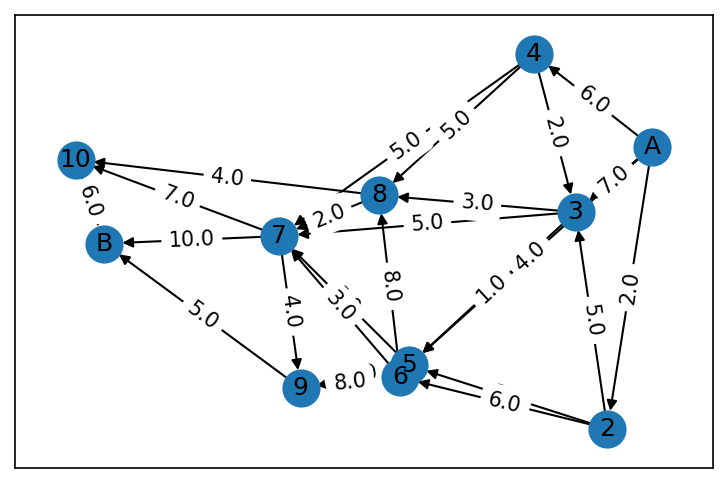

In [3]:
G = nx.DiGraph()

elist = [('A', '2', 2.0), ('A', '5', 4.0),('A', '3', 7.0), ('A', '4', 6.0),
         ('2', '3', 5.0), ('2', '5', 3.0), ('2', '6', 6.0), 
         ('3', '5', 1.0), ('3', '7', 5.0), ('3', '8', 3.0),
         ('4', '3', 2.0), ('4', '8', 5.0), ('4', '7', 5.0),
         ('5', '6', 2.0), ('5', '9', 10.0), ('5', '7', 6.0),
         ('6', '9', 8.0), ('6', '7', 3.0), ('6', '8', 8.0),
         ('7', '9', 4.0), ('7', 'B', 10.0), ('7', '10', 7.0),
         ('8', '7', 2.0), ('8', '10', 4.0), 
         ('9', 'B', 5.0),
         ('10', 'B', 6.0)
         ]
G.add_weighted_edges_from(elist)
# fixed_pos = {'A':(0, 0), '2': (1, 1), 'B': (20, -4)}
# fixed_nodes = fixed_pos.keys()
pos = nx.spectral_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

print(nx.shortest_path(G, source='A', target='B', weight='weight'))
print(nx.shortest_path_length(G, source='A', target='B', weight='weight'))

## Problem 2

For the first-order discrete system

$$
x_{k+1}=1.05 x_k +u_k
$$

The performance measure to be minimized is

$$
J=x(N)^2 + \frac{1}{2} \sum_{k=0}^{N-1} q x^2(k) + r u^2(k)
$$

a) For the case $N \to \infty$, solve the discrete equation for the
steady state $P$ and gain $F$ as a function of $q$ and $r$.

b) For $q=r=1$, confirm that the backwards recursion agrees with
this steady state prediction. Based on these results, how large do you
think $N$ needs to be before we can ignore the transient?

c) Compare the performance of the optimal controller ($q=r=1$) with
the ad-hoc design $u_k=-0.4x_k$.



In [4]:
n = 1                                # state dim
N = 20                               # LQR time steps

A = np.array([[1.05]])
B = np.array([[1.0]])
H = np.array([[2.0]])
Q = np.array([1])
R = np.array([1])
P = np.zeros((n,n,N+1))              # cost to go matrix

# backward recursion for P and F
F = np.zeros((1,n,N+1))              # gains
P[:,:,N] = H                         # P initialization
for k in np.arange(N-1,-1,-1):
    P[:,:,k] = Q+A.T@(P[:,:,k+1]-P[:,:,k+1]@B@B.T@P[:,:,k+1]/(R+B.T@P[:,:,k+1]@B))@A
    F[:,:,k] = B.T@P[:,:,k+1]@A/(R+B.T@P[:,:,k+1]@B)   

In [5]:
Pss = la.solve_discrete_are(A, B, Q, R)
print('P steady state value\n',Pss)
print('compare to P Numerical\n',P[:,:,0])

Fss = B.T@Pss@A/(R+B.T@Pss@B)
print('\nComputed Steady State Gain\n',Fss)
print('Compare to Numerical Gain\n',F[:,:,0])

P steady state value
 [[1.693124]]
compare to P Numerical
 [[1.693124]]

Computed Steady State Gain
 [[0.660118]]
Compare to Numerical Gain
 [[0.660118]]


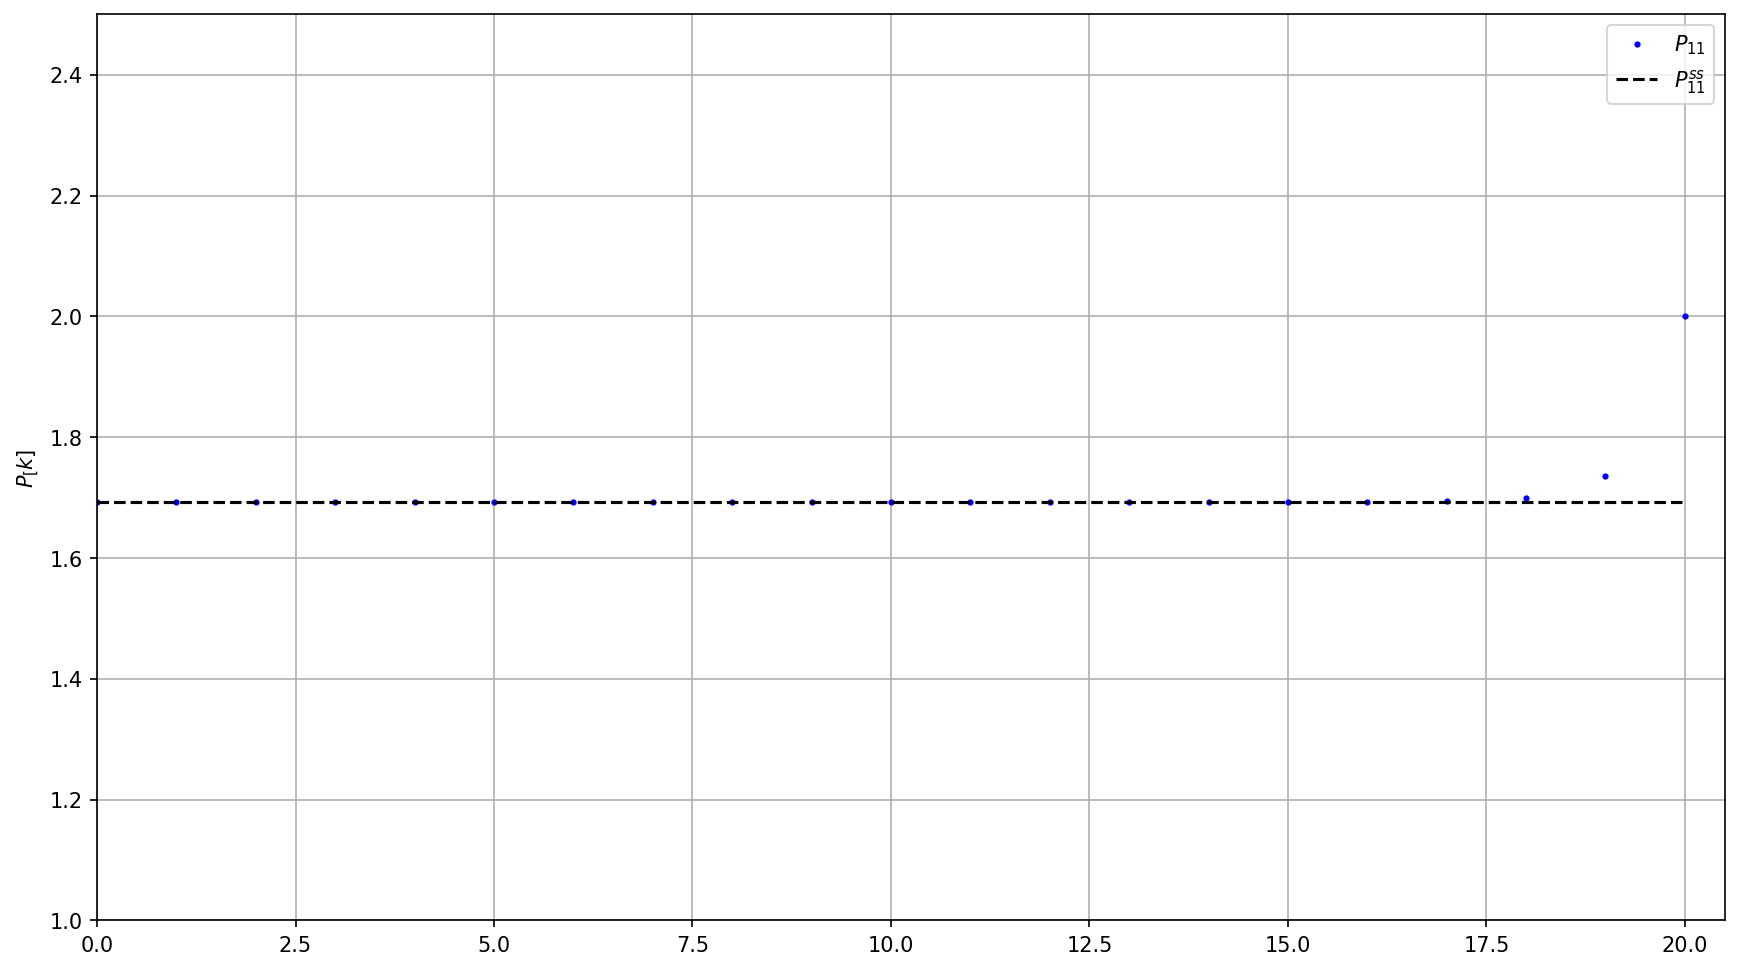

In [6]:
K=np.arange(0,N+1,1)

# for k in K:
#   print('Numerical P')
#   print(P[0, 0,k])
#   print('\nNumerical Gain')
#   print(F[0, 0,k])

plt.figure(1,figsize=(14,8))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(K,P[0,0,:],'bo',ms=2,label=r'$P_{11}$')
ax1.plot([0,N],[Pss[0,0],Pss[0,0]],'k--',label=r'$P^{ss}_{11}$')
plt.ylim([1,round(1.5*Pss[0,0],1)])
plt.xlim([0,N+0.5])
plt.ylabel(r'$P_[k]$')
plt.grid()
plt.legend(loc='best')

In [7]:
# state response
x0 = np.array([1])    # state initial condition
X = np.zeros((n,1,N+1))
X_opt = np.zeros((n,1,N+1))
X[:,0,0] = x0
X_opt[:,0,0] = x0

for k in np.arange(1,N+1,1):
        Acl = A - B@[0.4]
        Acl_opt = A - B@F[:,:,k]
        X[:,0,k] = Acl@X[:,0,k-1]
        X_opt[:,0,k] = Acl_opt@X_opt[:,0,k-1]

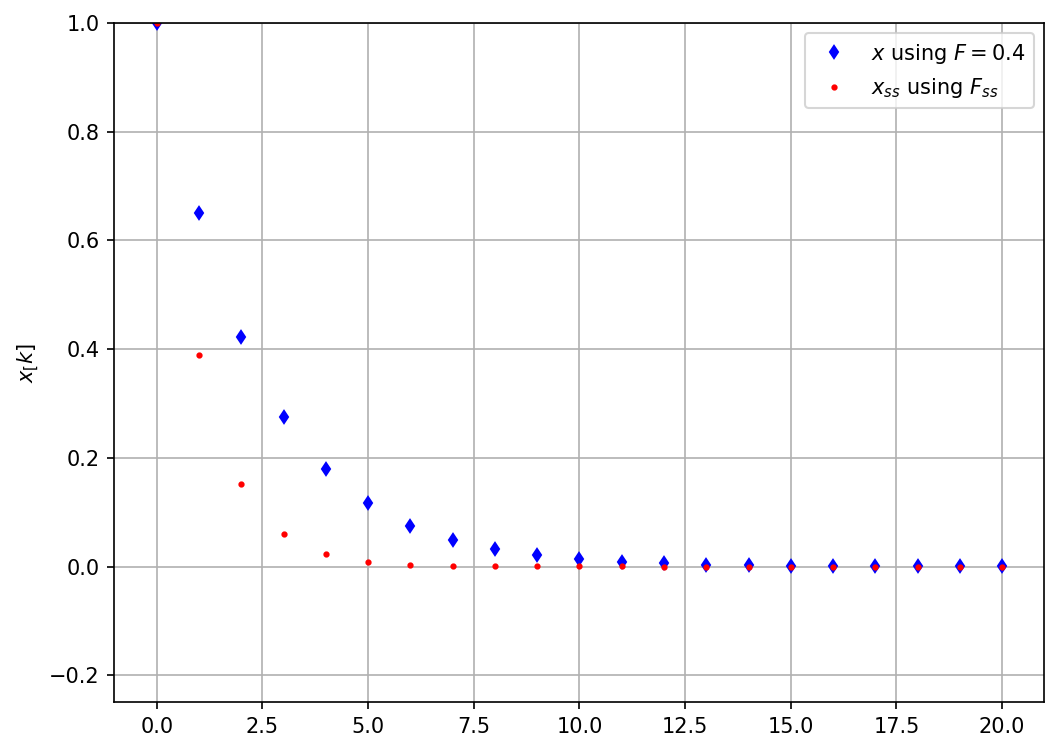

In [8]:
plt.figure(1,figsize=(8,6))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(K,X[0,0,:],'bd',ms=4,label=r'$x$ using $F = 0.4$')
ax1.plot(K,X_opt[0,0,:],'ro',ms=2,label=r'$x_{ss}$ using $F_{ss}$')
plt.ylim([-0.25,1.0])
plt.ylabel(r'$x_[k]$')
plt.grid()
plt.legend(loc='best')

## Problem 3

The in-plane linearized orbital dynamics for objects in close proximity are governed by the Clohessy-Wiltshire equations
\begin{eqnarray}
\ddot x(t) &=& 3n^2x(t) + 2n \dot y(t) + u_x\\
\ddot y(t) &=& -2n \dot x + u_y \\
\end{eqnarray}
where $n \approx 0.00113$ $s^{-1}$, corresponding to an orbital period of about 93 minutes.

The goal is to minimize the performance
measure
$$
J = 10^4 x^2(T) + \frac{1}{2} \int_0^T [x^2(t) + 0.2 y^2(t) + \rho(u_x^2(t)+u_y^2(t))] dt
$$
where the final time should correspond to 1/10 orbit ($T_f = 2\pi/n/10$), $\rho = 10^8$, and the states and control are not constrained by any boundaries. 

a) Find the optimal control law by integrating the continuous-time Riccati equation with an
integration interval of 0.02 and with $ P(T) = H $
$$
-\dot P(t) = P(t)A(t) + A(t)^TP(t) + Q(t) -
P(t)B(t)R^{-1}(t)B(t)^TP(t)
$$

b) Solve the steady state algebraic Riccati equation for the steady state gains. Confirm that the numerical steady state gains agree. Do the time-varying gains differ much over this time window?

c) Compare the state response to initial condition offsets in $x,y$ of 100m using both the time varying feedbck and the steady state control. Any noticeable differences?


In [9]:
nc = 0.00113 
n = 4                                 # state dim
dt = 0.02                           # integration delta t
Tf = 2*np.pi/nc/10                              # final time
p = 1e8 
Npts = round(Tf/dt)                   # number of integration pts    
t = np.linspace(0,Tf,Npts)
tau = Tf - t                          # backwards time for P matrix

A = np.array([
              [0, 1., 0, 0], 
              [3.*nc**2, 0, 0, 2.*nc],
              [0, 0, 0, 1.], 
              [0, -2.*nc, 0, 0]])      # dynamics matrix
B = np.array([
              [0, 0], 
              [1, 0], 
              [0, 0], 
              [0, 1]])# input matrix
H = np.array([[2e4, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]) # terminal state cost 
P = np.zeros((n,n,Npts))              # cost to go matrix
Rxx = np.array([[1, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0.2, 0], [0, 0, 0, 0]])      # state cost in LQR
Ruu = p * np.identity(2)                     # control cost in LQR

display(A)
display(B)
display(H)
display(P)
display(Rxx)
display(Ruu)

array([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 3.8307e-06,  0.0000e+00,  0.0000e+00,  2.2600e-03],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
       [ 0.0000e+00, -2.2600e-03,  0.0000e+00,  0.0000e+00]])

array([[0, 0],
       [1, 0],
       [0, 0],
       [0, 1]])

array([[20000.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.]])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

array([[1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0. ]])

array([[1.e+08, 0.e+00],
       [0.e+00, 1.e+08]])

In [10]:
def doty(y, t, A, B, Rxx, Ruu):
    n = A.shape[0]
    P = y.reshape(n,n)
    P = (P + P.T)/2                   # make sure that P is symmetric
    # print(P)
    # print(P@B)
    # print(np.linalg.inv(Ruu))
    dotP = P@A + A.T@P + Rxx - P@B@np.linalg.inv(Ruu)@B.T@P
    return dotP.reshape(n**2,)

# integrate P forward in tau (backward in t) from H
sol = odeint(doty, H.reshape(n*n,), t, args=(A, B, Rxx, Ruu))
Pss = la.solve_continuous_are(A, B, Rxx, Ruu)

In [11]:
print('P steady state value')
display(Matrix(np.round(Pss,4)))

print('compare to P Numerical')
display(Matrix(np.round(sol[-1,:].reshape(n,n),4)))

Kss = np.linalg.inv(np.atleast_2d(Ruu))@B.T@Pss
print(r'Computed Steady State Gain K')
display(Matrix(np.round(Kss,4)))

K = np.zeros((2,n,Npts))
for II in np.arange(0,Npts-1):
  K[:,:,Npts-1-II] = np.linalg.inv(Ruu)@B.T@sol[II,:].reshape(n,n)

print('Compare to Numerical Gain K')
display(Matrix(K[:,:,0])*100000000000.)
print(K[:,:,0])

P steady state value


⎡ 144.8128    10229.0399    2.4007    1789.8656 ⎤
⎢                                               ⎥
⎢10229.0399  1414132.4239  -799.8655  85630.3519⎥
⎢                                               ⎥
⎢  2.4007     -799.8655     43.1281   4400.0244 ⎥
⎢                                               ⎥
⎣1789.8656    85630.3519   4400.0244  954660.804⎦

compare to P Numerical


⎡ 144.6766    10216.7457    2.9045     1826.6012 ⎤
⎢                                                ⎥
⎢10216.7457  1411738.1365  -733.7125  91776.4921 ⎥
⎢                                                ⎥
⎢  2.9045     -733.7125     41.9989    4292.6683 ⎥
⎢                                                ⎥
⎣1826.6012    91776.4921   4292.6683  941199.4816⎦

Computed Steady State Gain K


⎡0.0001  0.0141  0.0  0.0009⎤
⎢                           ⎥
⎣ 0.0    0.0009  0.0  0.0095⎦

Compare to Numerical Gain K


⎡0  0  0  0⎤
⎢          ⎥
⎣0  0  0  0⎦

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]


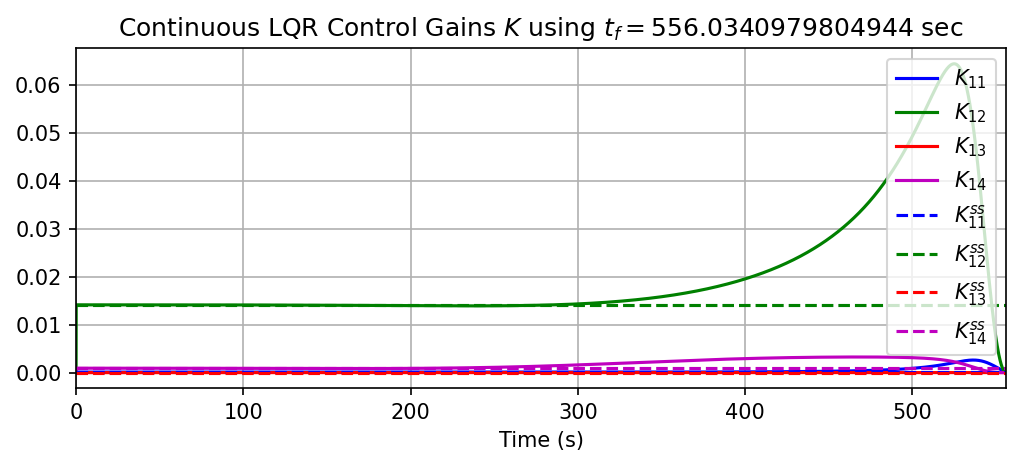

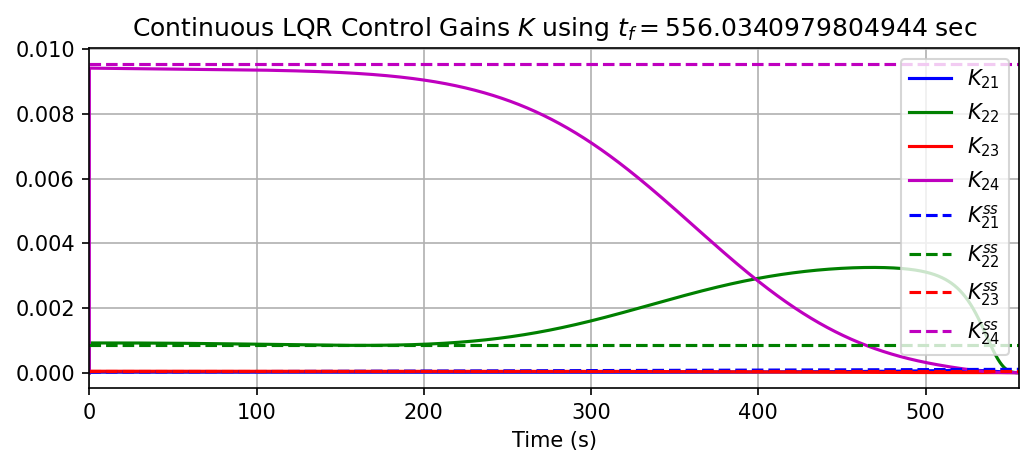

In [12]:
plt.figure(3,figsize=(8,3))
plt.plot(t[0:],K[0,0,:], 'b', label=r'$K_{11}$')
plt.plot(t[0:],K[0,1,:], 'g', label=r'$K_{12}$')
plt.plot(t[0:],K[0,2,:], 'r', label=r'$K_{13}$')
plt.plot(t[0:],K[0,3,:], 'm', label=r'$K_{14}$')
plt.plot([0,Tf],[Kss[0,0],Kss[0,0]],'b--',label=r'$K^{ss}_{11}$')
plt.plot([0,Tf],[Kss[0,1],Kss[0,1]],'g--',label=r'$K^{ss}_{12}$')
plt.plot([0,Tf],[Kss[0,2],Kss[0,2]],'r--',label=r'$K^{ss}_{13}$')
plt.plot([0,Tf],[Kss[0,3],Kss[0,3]],'m--',label=r'$K^{ss}_{14}$')
plt.legend()
plt.xlim([0,Tf])
plt.title('Continuous LQR Control Gains $K$ using $t_f=$'+str(Tf)+' sec')
plt.xlabel(r'Time (s)')
plt.grid()
plt.show()

plt.figure(3,figsize=(8,3))
plt.plot(t[0:],K[1,0,:], 'b', label=r'$K_{21}$')
plt.plot(t[0:],K[1,1,:], 'g', label=r'$K_{22}$')
plt.plot(t[0:],K[1,2,:], 'r', label=r'$K_{23}$')
plt.plot(t[0:],K[1,3,:], 'm', label=r'$K_{24}$')
plt.plot([0,Tf],[Kss[1,0],Kss[0,0]],'b--',label=r'$K^{ss}_{21}$')
plt.plot([0,Tf],[Kss[1,1],Kss[1,1]],'g--',label=r'$K^{ss}_{22}$')
plt.plot([0,Tf],[Kss[1,2],Kss[1,2]],'r--',label=r'$K^{ss}_{23}$')
plt.plot([0,Tf],[Kss[1,3],Kss[1,3]],'m--',label=r'$K^{ss}_{24}$')
plt.legend()
plt.xlim([0,Tf])
plt.title('Continuous LQR Control Gains $K$ using $t_f=$'+str(Tf)+' sec')
plt.xlabel(r'Time (s)')
plt.grid()
plt.show()

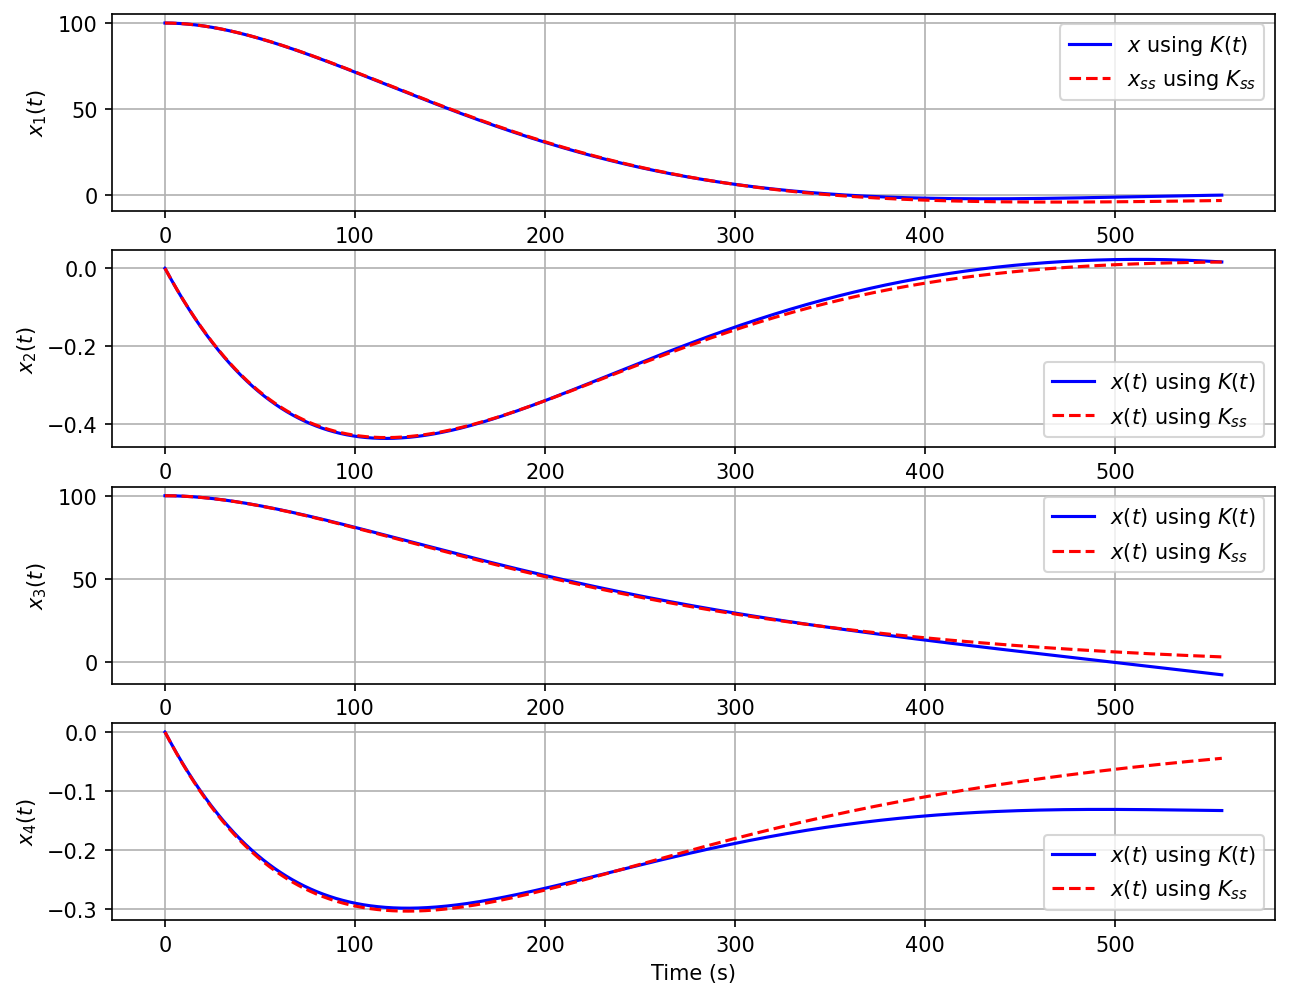

In [13]:
x0 = np.array([100, 0, 100, 0])    # state initial condition
X = np.zeros((n,1,Npts))
Xss = np.zeros((n,1,Npts))
U = np.zeros((2,1,Npts-1))
Uss = np.zeros((2,1,Npts-1))
X[:,0,0] = x0
Xss[:,0,0] = x0

for k in np.arange(0,Npts-1):
    Acl = A - B@K[:,:,k]
    Acl_ss = A - B@Kss
    U[:,0,k] = K[:,:,k]@X[:,0,k]
    Uss[:,0,k] = Kss@Xss[:,0,k]
    X[:,0,k+1] = X[:,0,k] + dt*Acl@X[:,0,k]
    Xss[:,0,k+1] = Xss[:,0,k] + dt*Acl_ss@Xss[:,0,k]

# J = 0.5*X[:,0,-1].T@H@X[:,0,-1] + 0.5*(np.sum(((X[:,0,:].T@Rxx).T)*X[:,0,:]) + np.sum((U*Ruu)*U))*dt
# Jss = 0.5*Xss[:,0,-1].T@H@Xss[:,0,-1] + 0.5*(np.sum(((Xss[:,0,:].T@Rxx).T)*Xss[:,0,:]) + np.sum((Uss*Ruu)*Uss))*dt

# print('Check cost value using CTG matrix ',round(0.5*x0@sol[-1,:].reshape(n,n)@x0,3))

plt.figure(3,figsize=(10,8))
ax1 = plt.subplot(411)
ax1.plot(t[0:],X[0,0,:],'b-',label=r'$x$ using $K(t)$')
ax1.plot(t[0:],Xss[0,0,:],'r--',label=r'$x_{ss}$ using $K_{ss}$')
plt.ylabel(r'$x_1(t)$')
plt.grid()

# plt.plot(np.NaN, np.NaN, '-', color='none', label='J = '+str(round(J,3)))
# plt.plot(np.NaN, np.NaN, '-', color='none', label=r'$J_{ss}$ = '+str(round(Jss,3)))
plt.legend(loc='best')
ax2 = plt.subplot(412, sharex=ax1)
ax2.plot(t,X[1,0,:],'b-',label=r'$x(t)$ using $K(t)$')
ax2.plot(t,Xss[1,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
plt.ylabel(r'$x_2(t)$')
plt.legend(loc='best')
plt.grid()

ax3 = plt.subplot(413, sharex=ax1)
ax3.plot(t,X[2,0,:],'b-',label=r'$x(t)$ using $K(t)$')
ax3.plot(t,Xss[2,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
plt.ylabel(r'$x_3(t)$')
plt.legend(loc='best')
plt.grid()

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(t,X[3,0,:],'b-',label=r'$x(t)$ using $K(t)$')
ax4.plot(t,Xss[3,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
plt.ylabel(r'$x_4(t)$')
plt.legend(loc='best')
plt.grid()
plt.xlabel(r'$k$')
plt.xlabel(r'Time (s)')
plt.show()

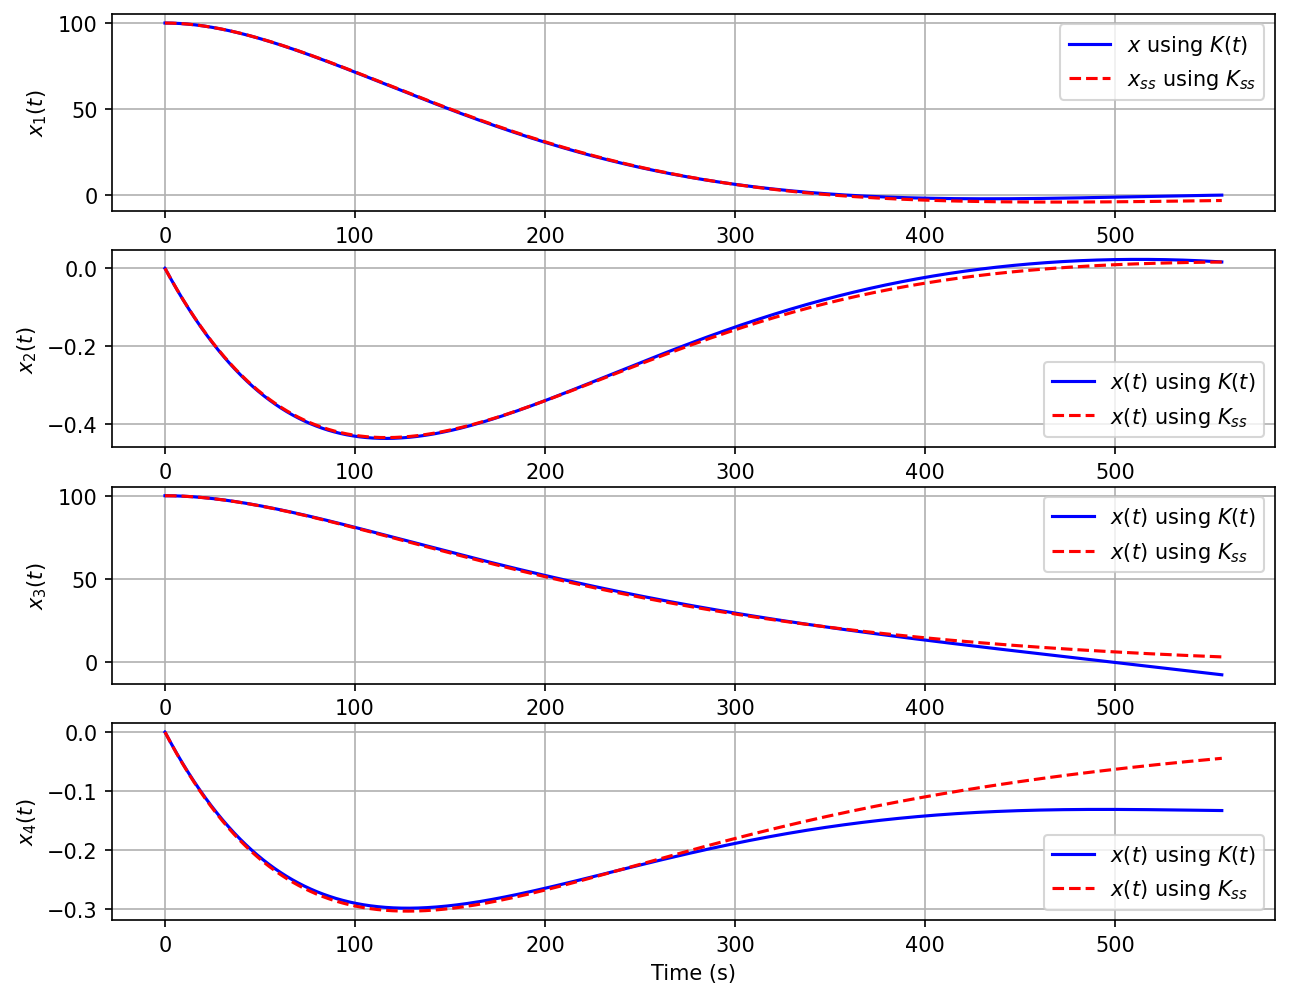

In [14]:
x0 = np.array([100, 0, 100, 0])    # state initial condition
X = np.zeros((n,1,Npts))
Xss = np.zeros((n,1,Npts))
U = np.zeros((2,1,Npts-1))
Uss = np.zeros((2,1,Npts-1))
X[:,0,0] = x0
Xss[:,0,0] = x0

for k in np.arange(0,Npts-1):
    Acl = A - B@K[:,:,k]
    Acl_ss = A - B@Kss
    U[:,0,k] = K[:,:,k]@X[:,0,k]
    Uss[:,0,k] = Kss@Xss[:,0,k]
    X[:,0,k+1] = X[:,0,k] + dt*Acl@X[:,0,k]
    Xss[:,0,k+1] = Xss[:,0,k] + dt*Acl_ss@Xss[:,0,k]

# J = 0.5*X[:,0,-1].T@H@X[:,0,-1] + 0.5*(np.sum(((X[:,0,:].T@Rxx).T)*X[:,0,:]) + np.sum((U*Ruu)*U))*dt
# Jss = 0.5*Xss[:,0,-1].T@H@Xss[:,0,-1] + 0.5*(np.sum(((Xss[:,0,:].T@Rxx).T)*Xss[:,0,:]) + np.sum((Uss*Ruu)*Uss))*dt

# print('Check cost value using CTG matrix ',round(0.5*x0@sol[-1,:].reshape(n,n)@x0,3))

plt.figure(3,figsize=(10,8))
ax1 = plt.subplot(411)
ax1.plot(t[0:],X[0,0,:],'b-',label=r'$x$ using $K(t)$')
ax1.plot(t[0:],Xss[0,0,:],'r--',label=r'$x_{ss}$ using $K_{ss}$')
plt.ylabel(r'$x_1(t)$')
plt.grid()

# plt.plot(np.NaN, np.NaN, '-', color='none', label='J = '+str(round(J,3)))
# plt.plot(np.NaN, np.NaN, '-', color='none', label=r'$J_{ss}$ = '+str(round(Jss,3)))
plt.legend(loc='best')
ax2 = plt.subplot(412, sharex=ax1)
ax2.plot(t,X[1,0,:],'b-',label=r'$x(t)$ using $K(t)$')
ax2.plot(t,Xss[1,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
plt.ylabel(r'$x_2(t)$')
plt.legend(loc='best')
plt.grid()

ax3 = plt.subplot(413, sharex=ax1)
ax3.plot(t,X[2,0,:],'b-',label=r'$x(t)$ using $K(t)$')
ax3.plot(t,Xss[2,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
plt.ylabel(r'$x_3(t)$')
plt.legend(loc='best')
plt.grid()

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(t,X[3,0,:],'b-',label=r'$x(t)$ using $K(t)$')
ax4.plot(t,Xss[3,0,:],'r--',label=r'$x(t)$ using $K_{ss}$')
plt.ylabel(r'$x_4(t)$')
plt.legend(loc='best')
plt.grid()
plt.xlabel(r'$k$')
plt.xlabel(r'Time (s)')
plt.show()

## Problem 4

(Thrun, Burgard and Fox) Consider a robot moving in an environment with 2D static landmarks. The discretized robot kinematics are

$$
\mathbf{x}_{k+1} =
f(\mathbf{x}_k,\mathbf{u}) = 
\begin{pmatrix}
x_k \\
y_k \\
\theta_k
\end{pmatrix} + 
\begin{pmatrix}
-\frac{v}{\omega}\sin{\theta_k} + \frac{v}{\omega}\sin{(\theta_k + \omega \Delta t)} \\
\frac{v}{\omega}\cos{\theta_k} - \frac{v}{\omega}\cos{(\theta_k + \omega \Delta t)} \\
\omega \Delta t
\end{pmatrix}
$$

with the control input $\mathbf{u}=\begin{pmatrix}\bar{v}&\bar{\omega}\end{pmatrix}^\top$, where $\bar{v}$ is the desired linear velocity (in the direction of the robot's heading, $\theta$) and $\bar{\omega}$ the desired angular velocity. To account for nonlinear effects such as wheel slip and friction, we add Gaussian noise to the desired velocity command such that

$$
\mathbf{u} = \begin{pmatrix} v \\ \omega \end{pmatrix} =
\begin{pmatrix} \bar{v} \\ \bar{\omega} \end{pmatrix} +
\begin{pmatrix} \eta_v \\ \eta_\omega \end{pmatrix}
$$

where $\eta_v\sim\mathcal{N}(0, \alpha_1 v^2 + \alpha_2 \omega^2)$ and $\eta_\omega\sim\mathcal{N}(0, \alpha_3 v^2 + \alpha_4 \omega^2)$.

The robot is equipped with a camera that allows it to measure range and bearing to observed landmarks. At each timestep, a single randomly selected landmark is observed. The robot knows which landmark it is observing (i.e., data association is assumed known). Given a landmark position $L\in\mathbb{R}^2$, the measurement model is

$$
h(\mathbf{x}_k; L) = 
\begin{pmatrix}
\| \mathbf{x}_k - L\| \\
\arctan{\frac{L_y - \mathbf{x}_{k,y}}{L_x - \mathbf{x}_{k,x}}} - \mathbf{x}_{k,\theta}
\end{pmatrix}.
$$

Using these models, implement a UKF to localize the position and heading of the robot given measurements to known landmark positions. Much of the code has been written for you---your task is to implement the `filter` method of the `UKF` class below.

**(Optional)** The UKF outlined in lecture 12 slides is for *additive* noise (i.e., $\dot{x}=f(x,u)+w$) but the model given above has non-additive noise entering the dynamics via the input. In this case, the unscented transform is applied to the *augmented* state, $\mu=\begin{pmatrix}\mathbf{x}_k^\top & \mathbf{0}^\top & \mathbf{0}^\top \end{pmatrix}^\top$ with augmented covariance $\Sigma=\mathrm{blkdiag}(Q, W, V)$. In this case, sigma points only need to be generated once time for propagation, instead of for both the propagation and measurement update steps. Consider implementing an augmented UKF and comparing performance for different noises. Which one performs better for a wider range of tuning? See Thrun et al., *Probabilistic Robotics*, Section 7.7 for more information and pseudocode.

### Robot Simulation Class

This class simulates the robot using the nonlinear motion and measurement models described above.

In [15]:
class Robot:
    """
    Velocity-controlled two-wheeled robot (e.g., think Roomba)
    
    The robot has state (x, y, θ) with motion model as
    described in Probabilistic Robotics by Thrun ch. 5d
    """
    def __init__(self, dt, x0, L):
        """
        Constructor
        
        Parameters
        ----------
        dt : float
            time step
        x0 : (3,) np.array
            (unknown) true initial state - (x, y, θ)
        L : (2,m) np.array
            known 2D static landmark positions
        """
        self.dt = dt
        self.L = L
        
        self.x = copy.deepcopy(x0) # unknown true state
        
        # state and control history
        self.xh = [copy.deepcopy(x0)]
        self.uh = []
        
        # (unknown) measurement noise for each landmark
        self.R = np.diag([0.03, 0.05])
        
    @staticmethod
    def W(u, alphas=[0.1, 0.01, 0.01, 0.1]):
        """
        Generate processn noise covariance matrix
        
        The process noise is due to the fact that velocity commands
        are not instantaneously achieved because of effects such
        as wheel slippage, friction, etc.
        
        Parameters
        ----------
        u : (2,) np.array
            velocity command: (v, ω)
        alphas : 4-list
            noise characteristics
            
        Returns
        -------
        W : (2,) np.array
            process noise covariance matrix
        """
        
        # create variance according to noise model
        var1 = alphas[0] * u[0]**2 + alphas[1] * u[1]**2
        var2 = alphas[2] * u[0]**2 + alphas[3] * u[1]**2
        return np.diag([var1, var2])
    
    @staticmethod
    def f(x, u, dt):
        """
        Motion model of robot
        
        Parameters
        ----------
        x : (3,) np.array
            current state
        u : (2,) np.array
            velocity command
            
        Returns
        -------
        xp : (3,) np.array
            propagated state
        """
        # for brevity
        v, ω = u
        sθ = np.sin(x[2])
        cθ = np.cos(x[2])
        sθω = np.sin(x[2] + ω * dt)
        cθω = np.cos(x[2] + ω * dt)

        # propagate state forward
        xp = np.zeros_like(x)
        xp[0] = x[0] - v/ω * sθ + v/ω * sθω
        xp[1] = x[1] + v/ω * cθ - v/ω * cθω
        xp[2] = x[2] + ω * dt
        
        return xp
    
    @staticmethod
    def h(x, L):
        """
        Measurement model for range and bearing sensor
        
        Parameters
        ----------
        x : (3,) np.array
            current state
        L : (p,2) np.array
            true positions of p observed 2D landmarks
            
        Returns
        -------
        z : (2*p,) np.array
            range and bearing measurements to each observed landmark
        """
        p = L.shape[0]
        if len(x.shape) == 1:
            z = np.zeros((2*p,))
        elif len(x.shape) == 2: # handle particle set inputs
            z = np.zeros((2*p,x.shape[1]))
        
        for i, l in enumerate(L):
            z[2*i] = np.linalg.norm(x[:2].reshape((2,-1)) - l.reshape((2,1)), axis=0)
            z[2*i+1] = np.arctan2(l[1] - x[1], l[0] - x[0]) - x[2]

        return z
    
    def move(self, u):
        """
        Physics simulation of robot
        
        Parameters
        ----------
        u : (2,) np.array
            velocity command: (v, ω)
        """

        # add noise to desired commands
        unoisy = np.random.multivariate_normal(u, self.W(u))
        
        # propagate state forward
        self.x = self.f(self.x, unoisy, self.dt)
        
        # keep history
        self.uh.append(copy.deepcopy(unoisy))
        self.xh.append(copy.deepcopy(self.x))
    
    def sense(self):
        """
        Use simulated sensor to gather range and bearing measurements
        
        Only a single landmark is measured. It is selected randomly.
        Data association is assumed solved, i.e., landmarks have unique
        IDs and it is known which landmark a measurement is associated with.
        
        Returns
        -------
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # randomly select p landmarks
        p = 1
        l = np.random.choice(len(self.L), p, replace=False)
        
        # simulate measurements
        z = self.h(self.x, self.L[l])
        
        # add noise
        z += np.random.multivariate_normal(np.zeros(2*p), la.block_diag(*[self.R]*p))
            
        return z, l

In [16]:
def π(t):
    """
    Control policy to generate velocity commands
    
    Parameters
    ----------
    t : float
        current time
        
    Return
    ------
    u : (2,) np.array
        velocity command (v, ω)
    """
    v =  1.0 + 0.5 * np.cos(2 * np.pi * 0.2 * t)
    ω = -0.2 + 2.0 * np.cos(2 * np.pi * 0.6 * t)
    return np.array([v,ω])

### UKF Implementation - Your Code Here

In [26]:
class UKF:
    """
    Unscented Kalman Filter
    """
    def __init__(self, robot, x0, Q0):
        """
        Constructor
        
        Parameters
        ----------
        robot : Robot
            Robot object describing the process we are filtering for
        x0 : (3,) np.array
            initial state for filter (ideally as close to actual robot as possible)
        Q0 : (3,3) np.array
            initial estimation error covariance (commensurate with belief in x0)
        """
        
        # filter state and estimation error covariance
        self.xhat = copy.deepcopy(x0)
        self.Q = copy.deepcopy(Q0)
        
        # filter state and cov history
        self.xhath = [copy.deepcopy(x0)]
        self.Qh = [copy.deepcopy(Q0)]
        
        # hold onto robot model for dynamics, landmark positions, etc
        self.robot = robot
        
        # motion and measurement model to use
        # n.b., this assumes we have perfect model knowledge
        self.f = robot.f
        self.h = robot.h
        
        self.W = np.diag([1., 1., 1.])*0.1
        self.R = robot.R*10

        # additional parameters, from UT Weights - 2
        self.α = 0.1
        self.β = 2
    
    def filter(self, u, z, l):
        """
        Applies the UKF at the current time step
        
        Parameters
        ----------
        u : (2,) np.array
            desired velocity command: (v, ω)
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # dimensions and stuff
        n, = self.xhat.shape  # num states
        k, = u.shape          # num inputs
        mm, = z.shape         # num measurements

        # # unscented transform weights
        # Wm = np.zeros(2*n+1)
        # Wc = np.zeros(2*n+1)
        # κ = 3 - n

        # λ = self.α**2 * (n+κ) - n
        # Wm[0] = λ / (n + λ)
        # Wc[0] = λ / (n + λ) + (1-self.α**2+ self.β)
        # Wm[1:] = 1 / (2. * (n + λ))
        # Wc[1:] = 1 / (2. * (n + λ))
        
        # creating sigma points
        sp = np.zeros((n, 2*n+1))
        sp[:,0] = self.xhat
        for i  in range(1, n+1):
          sp[:,i] = self.xhat + scipy.linalg.sqrtm(n*self.Q)[:,i-1]
          sp[:,n+i] = self.xhat - scipy.linalg.sqrtm(n*self.Q)[:,i-1]
        
        # propagate sigma points
        xk = self.f(sp, u, self.robot.dt)

        # using propagated sigma points to approximate new xkm and Qkm
        w = 1/(2*n+1)
        xkm = np.sum(w*xk, axis=1)
        Qkm = np.zeros((n, n))

        for i in range(2*n+1):
          Qkm += w*(xk[:,i]-xkm).reshape(n, 1) @ (xk[:,i]-xkm).reshape(1, n)
        Qkm += self.W

        # use same sigma points to get Qyy and Qxy
        y_sp = self.h(sp, self.robot.L[l,:])
        ykm = np.sum(w*y_sp, axis=1)

        Qyy = np.zeros((mm, mm))
        Qxy = np.zeros((n, mm))

        for i in range(2 * n+1):
          Qyy += w * (y_sp[:,i]-ykm).reshape(mm, 1) @ (y_sp[:,i] -ykm).reshape(1, mm)
          Qxy += w * np.dot( (xk[:,i]-xkm).reshape(n, 1), (y_sp[:,i] - ykm).reshape(1, mm))
        
        Qyy += self.R

        Lk = Qxy @ np.linalg.inv(Qyy)
        self.xhat = xkm + Lk@(z-ykm)
        self.Q = Qkm - Lk@Qyy@Lk.T

        # logging
        self.xhath.append(copy.deepcopy(self.xhat))
        self.Qh.append(copy.deepcopy(self.Q))

### Simulation

The following code sets up the simulation loop with the appropriate landmark positions.

In [27]:
dt = 0.1
tvec = np.arange(0,20+dt,dt)

# initial conditions
x0 = np.array([-5, -3, np.pi/2])
Q0 = np.diag([1., 1., 1.])*1e-3

# known landmark positions
L = np.array([[6., 4.],[-7., 8.],[6., -4.]])

robot = Robot(dt, x0, L)
ukf = UKF(robot, x0, Q0)

In [28]:
for t in tvec:
    
    # use policy to generate desired command
    u = π(t)
    
    # ------------ Robot simulation (i.e., the plant) ------------
    
    # move the robot
    robot.move(u)
    
    # sense the environment
    z, l = robot.sense()
    
    # ------------------------------------------------------------
    
    # perform UKF localization (i.e., estimate robot state (x, y, θ))
    ukf.filter(u, z, l)

### Plotting Code

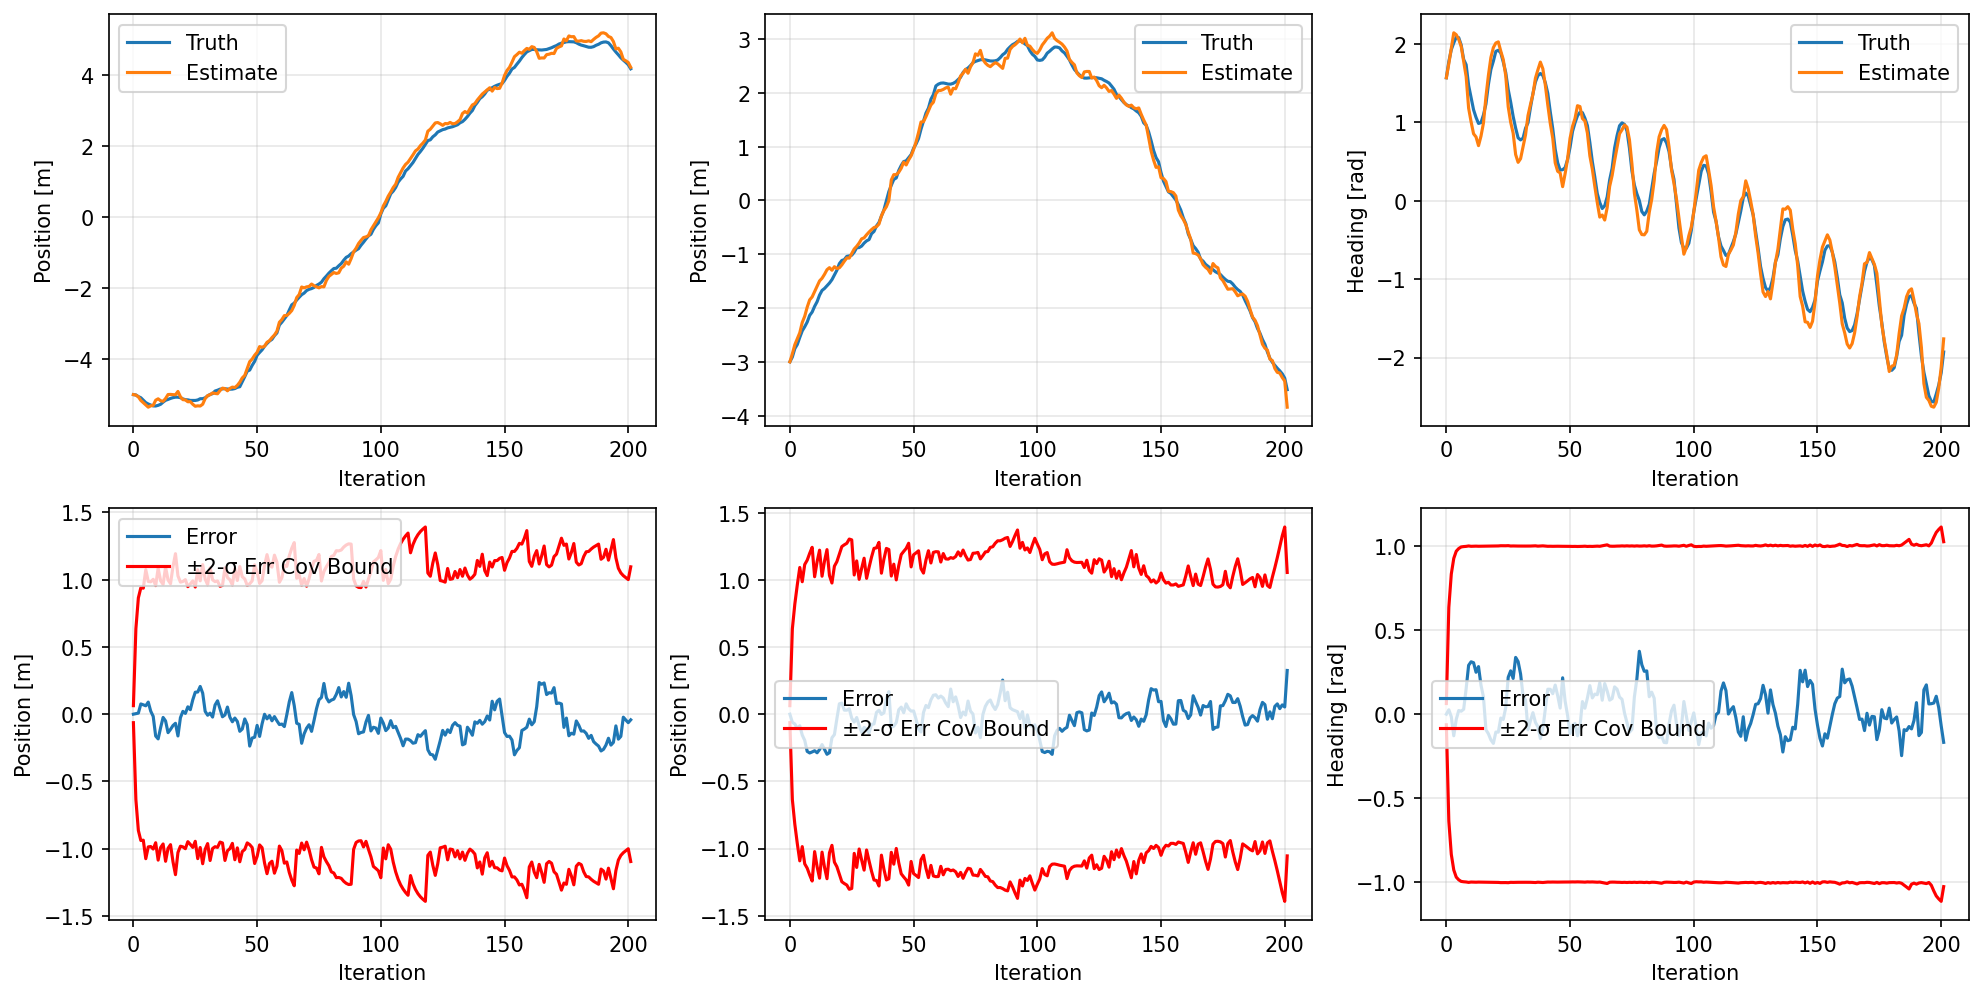

In [29]:
xgt = np.array(robot.xh)
xhat = np.array(ukf.xhath)
xerr = xgt - xhat
Qdiag = np.array([np.diag(Q) for Q in ukf.Qh]) # variances of est err
σbnd = 2

fig, ax = plt.subplots(2,3,figsize=(16,8))

ylabels = ['Position [m]', 'Position [m]', 'Heading [rad]']

for i in range(3):
    ax[0][i].plot(xgt[:,i],label='Truth')
    ax[0][i].plot(xhat[:,i],label='Estimate')
    ax[0][i].set_xlabel('Iteration')
    ax[0][i].set_ylabel(ylabels[i])
    ax[0][i].legend()
    ax[0][i].grid(alpha=0.3)
    
for i in range(3):
    ax[1][i].plot(xerr[:,i],label='Error')
    ax[1][i].plot( σbnd*np.sqrt(Qdiag[:,i]), label=f'±{σbnd}-σ Err Cov Bound', color='r')
    ax[1][i].plot(-σbnd*np.sqrt(Qdiag[:,i]), color='r')
    ax[1][i].set_xlabel('Iteration')
    ax[1][i].set_ylabel(ylabels[i])
    ax[1][i].legend()
    ax[1][i].grid(alpha=0.3)

### Animation Code for Visualization

In [30]:
class LocalizationAnimation:
    """
    Utility to visualize robot localization problem
    """
    def __init__(self, robot, ukf):
        """
        Constructor
        
        Parameters
        ----------
        robot : Robot
            Robot object containing state history
        ukf : UKF
            UKF object containing state history
        """
        self.robot = robot
        self.ukf = ukf
    
    def animate(self):
        """
        Generate an animation as an HTML5 video
        """
        X = np.array(self.robot.xh)
        Xhat = np.array(self.ukf.xhath)
        
        dt = self.robot.dt
        T = X.shape[0]
        
        xm = -20
        xM = 20
        ym = -20
        yM = 20
        
        env = plt.figure(figsize=(8, 8), dpi=100)
        ax = env.add_subplot(1, 1, 1)
        ax.set_xlim((xm, xM))
        ax.set_ylim((ym, yM))
        ax.set_title("Robot Environment",fontsize=20)
        ax.set_xlabel("X position [m]", fontsize=16)
        ax.set_ylabel("Y position [m]", fontsize=16)
        
        gt_robot = plt.Circle((X[0, 0], X[0, 1]), 1, fill=False)
        ax.add_artist(gt_robot)
        gt_dir = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        gt_line, = ax.plot(X[0,0] + gt_dir[0, :], X[0,1] + gt_dir[1, :], 'k', label='Ground Truth')
        gt_traj, = ax.plot(X[0,0], X[0,1], 'k:')
        
        est_robot = plt.Circle((X[0,0], X[0,1]), 1, fill=False, color='r')
        ax.add_artist(est_robot)
        est_dir = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        est_line, = ax.plot(Xhat[0,0] + est_dir[0, :], Xhat[0,1] + est_dir[1, :], 'r', label='Estimate')
        est_traj, = ax.plot(Xhat[0,0], Xhat[0,1], 'r')
        
        ax.plot(self.robot.L[:, 0], self.robot.L[:, 1], 'gD', label='Landmarks')
        
        ax.legend()
        def animate(i):
            gt_dir = np.array([[0, np.cos(X[i, 2])], [0, np.sin(X[i, 2])]])
            gt_line.set_data(X[i,0] + gt_dir[0, :], X[i,1] + gt_dir[1, :])
            gt_robot.center = X[i,0], X[i,1]
            gt_traj.set_data(X[:i,0], X[:i,1])
            
            est_dir = np.array([[0, np.cos(Xhat[i, 2])], [0, np.sin(Xhat[i, 2])]])
            est_line.set_data(Xhat[i,0] + est_dir[0, :], Xhat[i,1] + est_dir[1, :])
            est_robot.center = Xhat[i,0], Xhat[i,1]
            est_traj.set_data(Xhat[:i,0], Xhat[:i,1])
            return (gt_line,gt_traj,est_line,est_traj,)
        
        anim = animation.FuncAnimation(env, animate, frames=T, interval=dt*500, blit=True)
        return anim.to_html5_video()

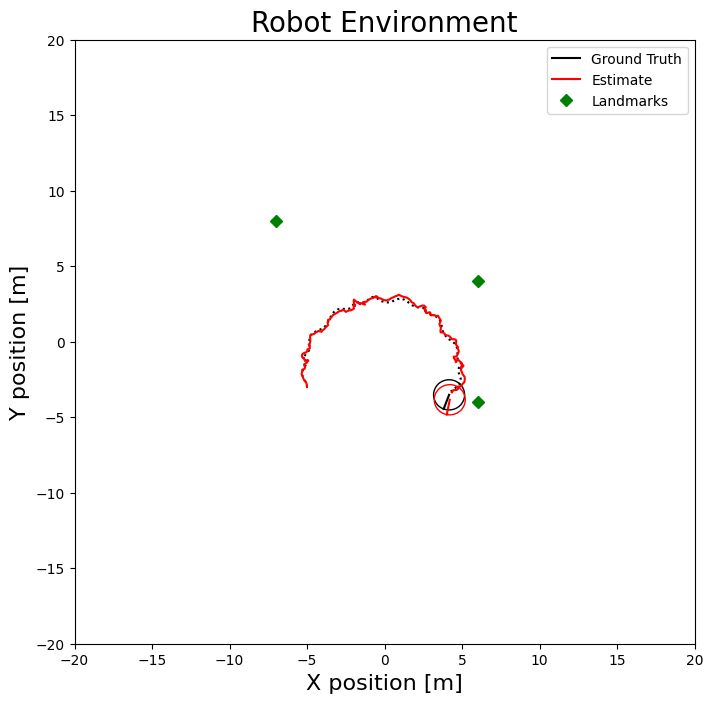

In [31]:
# generate animation - will take ~20 seconds to make video
ani = LocalizationAnimation(robot, ukf)
HTML(ani.animate())